In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from math import sqrt

In [2]:
# Convert colour hex values to 8bit RGB:
lego_colours = pd.read_csv('colors.csv', index_col='id')

In [3]:
lego_colours = lego_colours.drop([-1, 64, 9999], axis=0)

In [4]:
solid_lego_colours = lego_colours[lego_colours['is_trans'] == 'f']

In [5]:
solid_lego_colours = solid_lego_colours.rename(columns={'rgb': 'hex'})

In [6]:
# Remove the different versions of black
solid_lego_colours = solid_lego_colours[solid_lego_colours['hex'] != '000000']

In [7]:
rgb_values = []
for hex_val in solid_lego_colours['hex']:
    h = hex_val.lstrip('#')
    rgb_val = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    rgb_values.append(rgb_val)

solid_lego_colours['RGB'] = rgb_values

In [27]:
len(solid_lego_colours['RGB'])

101

In [148]:
image = Image.open('Mou-Aysha-portrait-photography-3.jpg')

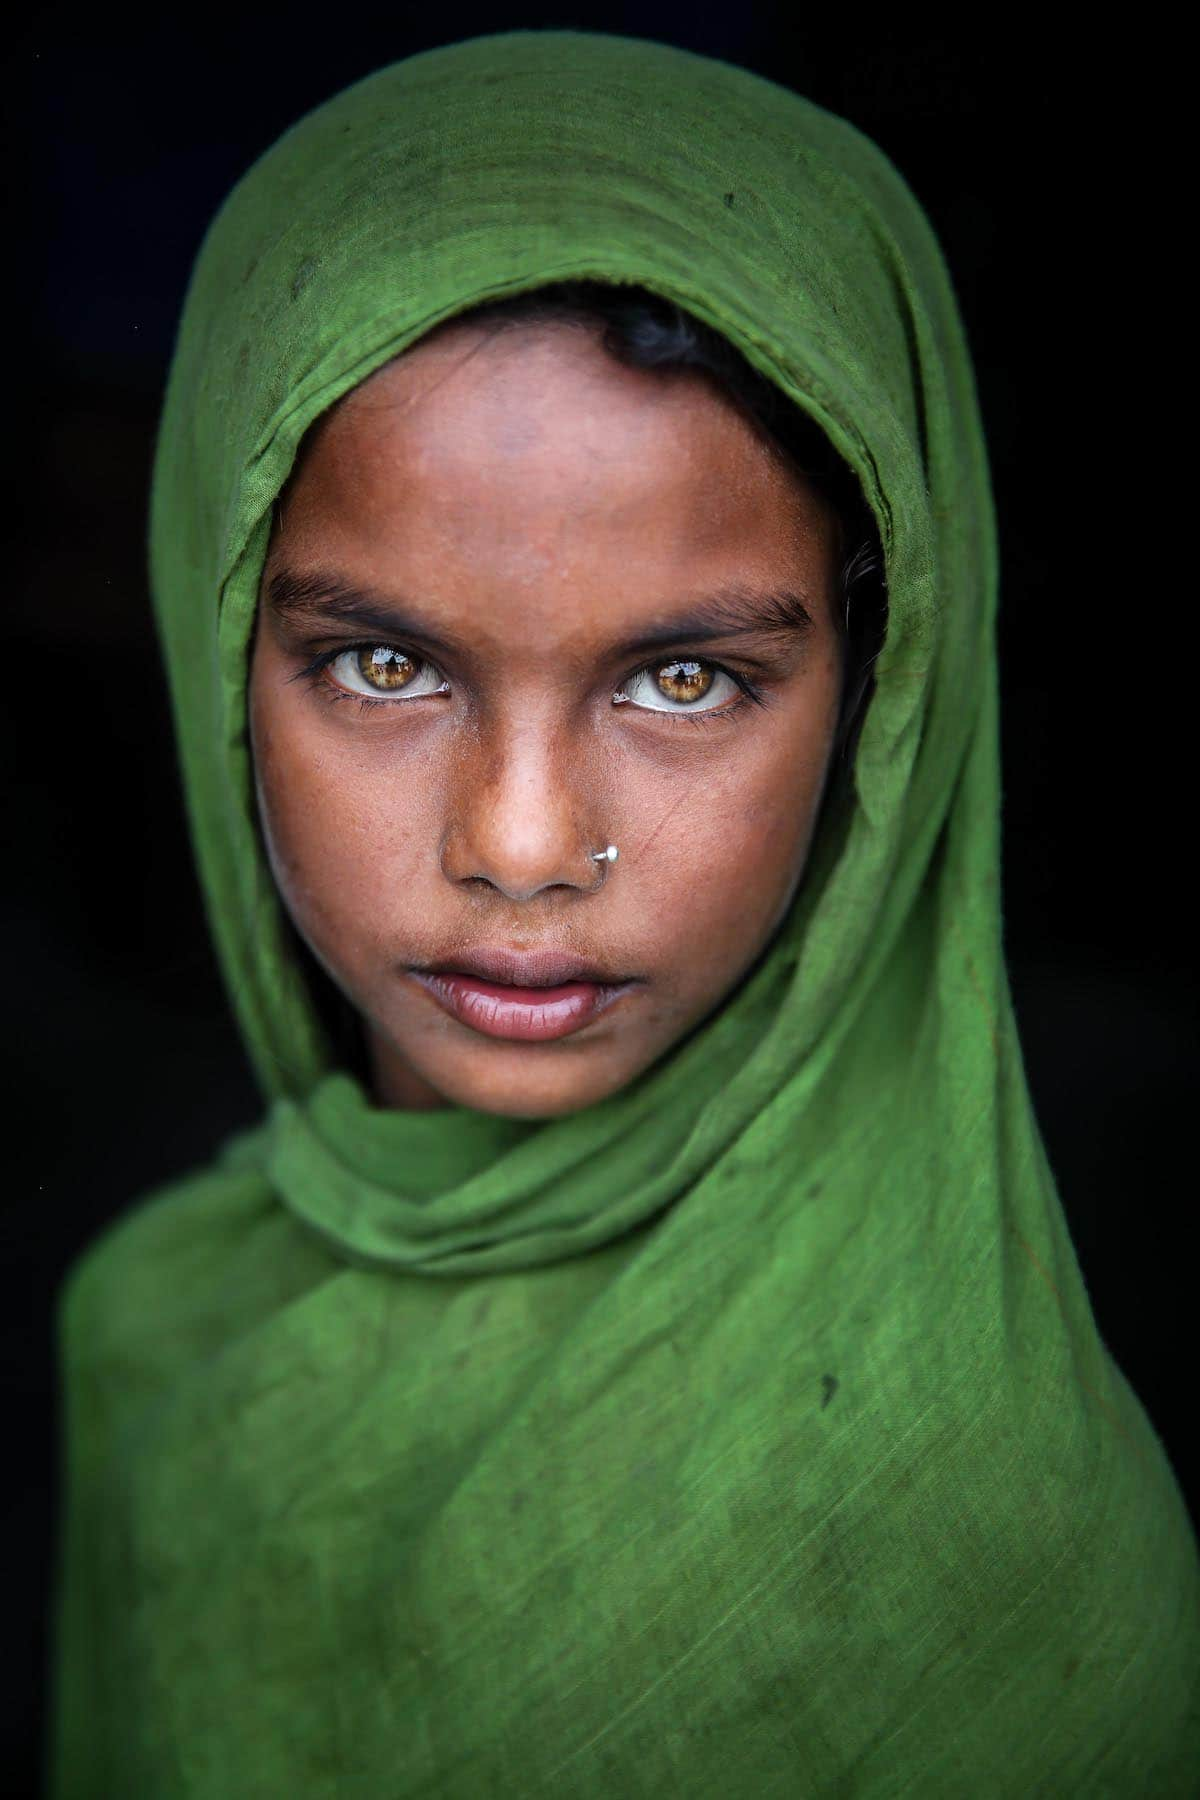

In [149]:
image

In [150]:
ratio = image.size[1]/image.size[0]
print(f'Your image is of size {image.size[1]} x {image.size[0]} px and has a ratio of: {ratio}')

Your image is of size 1800 x 1200 px and has a ratio of: 1.5


In [152]:
painting_base_size = int(input('Enter base size for the painting in mm. Value must be an integer: '))

Enter base size for the painting in mm. Value must be an integer: 500


In [153]:
painting_size = (painting_base_size, int(painting_base_size * ratio))
lego_painting_size = (int(painting_size[0]/7.8), int(painting_size[1]/7.8))
number_of_lego_pixels = lego_painting_size[0] * lego_painting_size[1]
actual_size = (round(lego_painting_size[0]*7.8, 2), round(lego_painting_size[1]*7.8, 2))
print(f'The actual size will be {actual_size[0]} x {actual_size[1]} mm.')
print(f'The painting will have {number_of_lego_pixels} pieces, arranged in {lego_painting_size[0]} x {lego_painting_size[1]} grid.')

The actual size will be 499.2 x 748.8 mm.
The painting will have 6144 pieces, arranged in 64 x 96 grid.


In [154]:
square_pixel_num = int(image.size[1]/lego_painting_size[0])
print(f'The original image will be divided into squares of size {square_pixel_num} px.')
print('These squares will form the lego "pixels" to be used.')

The original image will be divided into squares of size 28 px.
These squares will form the lego "pixels" to be used.


In [155]:
# Determine the crop size in proportion to the lego brick
actual_width = lego_painting_size[0] * square_pixel_num
actual_height = lego_painting_size[1] * square_pixel_num
print(f'The original image will be resized to {actual_width} x {actual_height} px, to fit the lego pixelisation.')

The original image will be resized to 1792 x 2688 px, to fit the lego pixelisation.


In [156]:
print('resizing...')

# Resize image
image = image.resize((actual_width, actual_height), Image.BICUBIC)
print(image.size)

resizing...
(1792, 2688)


In [157]:
# Crop the image in proportion to the lego brick
crop_x = int((image.size[0] - actual_width) / 2)
crop_y = int((image.size[1] - actual_height) / 2)
image = image.crop((crop_x, crop_y, crop_x + actual_width, crop_y + actual_height))
print(image.size)

(1792, 2688)


In [158]:
def split_image(img, square_size):
    """
    A function to divide the image into squares of square_size.
    Returns chunks of the original pillow image.
    """
    
    # Get the image size
    width, height = img.size

    # Split the image into 14x14 chunks
    for y in range(0, height, square_size):
        for x in range(0, width, square_size):
            box = (x, y, x + square_size, y + square_size)
            yield img.crop(box)

In [159]:
lego_pixel_list = []

# Feed the image trough the splittier and then convert the chunks into np arrays
# Store the converted chunks in a list
for chunk in split_image(image, square_pixel_num):
    chunk = np.array(chunk)
    lego_pixel_list.append(chunk)
    
print(f'The images was split into {len(lego_pixel_list)} chunks.')
print(f'This should be the same as the number of lego bricks calculated before: {number_of_lego_pixels}')

The images was split into 6144 chunks.
This should be the same as the number of lego bricks calculated before: 6144


In [160]:
mean_colour_list = []

# Take the chuks and find the mean colour that represent all of the pixels in them
# Store that mean colour in a list
for crop in lego_pixel_list:
    mean_colour_list.append(np.uint8(np.mean(crop, axis=(0, 1))))

print(f'The list of chunks was converted into {len(mean_colour_list)} mean colours.')
print(f'This should be the same as the number of lego bricks calculated before: {number_of_lego_pixels}')

The list of chunks was converted into 6144 mean colours.
This should be the same as the number of lego bricks calculated before: 6144


In [161]:
def closest_color(rgb_value, list_of_colours_to_check):
    """
    This function uses eucledian distance in R, G and B dimentions
    to find what colour (from a list of given colours) is closest
    to the given colour (rgb_value) in the input.
    """
    r, g, b = rgb_value
    color_diffs = []
    for color in list_of_colours_to_check:
        cr, cg, cb = color
        color_diff = sqrt((r - cr)**2 + (g - cg)**2 + (b - cb)**2)
        color_diffs.append((color_diff, color))
    return min(color_diffs)[1]

In [162]:
indexed_colour_list = []

# Go through all the colours in the list of mean colours and find which
# of the available solid lego colours is closest in colour value
for elem in mean_colour_list:
    indexed_colour_list.append(solid_lego_colours[solid_lego_colours['RGB'] == closest_color(elem, solid_lego_colours['RGB'])].index.values)

print(f'The mean colours have been converted to {len(indexed_colour_list)} LEGO colours.')

The mean colours have been converted to 6144 LEGO colours.


In [163]:
# Flatten the list so that from a list of arrays we have a list of values
indexed_colour_list = list(np.concatenate(indexed_colour_list).flat)

# Convert the list to a numpy array
indexed_colour_list = np.array(indexed_colour_list)

# Reshape the numpy array from 1D to 2D (to form back an image)
indexed_colour_list = indexed_colour_list.reshape(lego_painting_size[1], lego_painting_size[0])  # row, cols

In [164]:
hex_values_list = []

# Create a hex values list to be used for visualisation (as a colour map)
for value in solid_lego_colours['hex']:
    hex_values_list.append(f'#{value}')
    
custom_cmap = colors.ListedColormap(hex_values_list)

bounds = []
for i in range(len(solid_lego_colours.index)):
    bound = solid_lego_colours.index[i] - 0.2
    bounds.append(bound)
#bounds = [0] + bounds
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

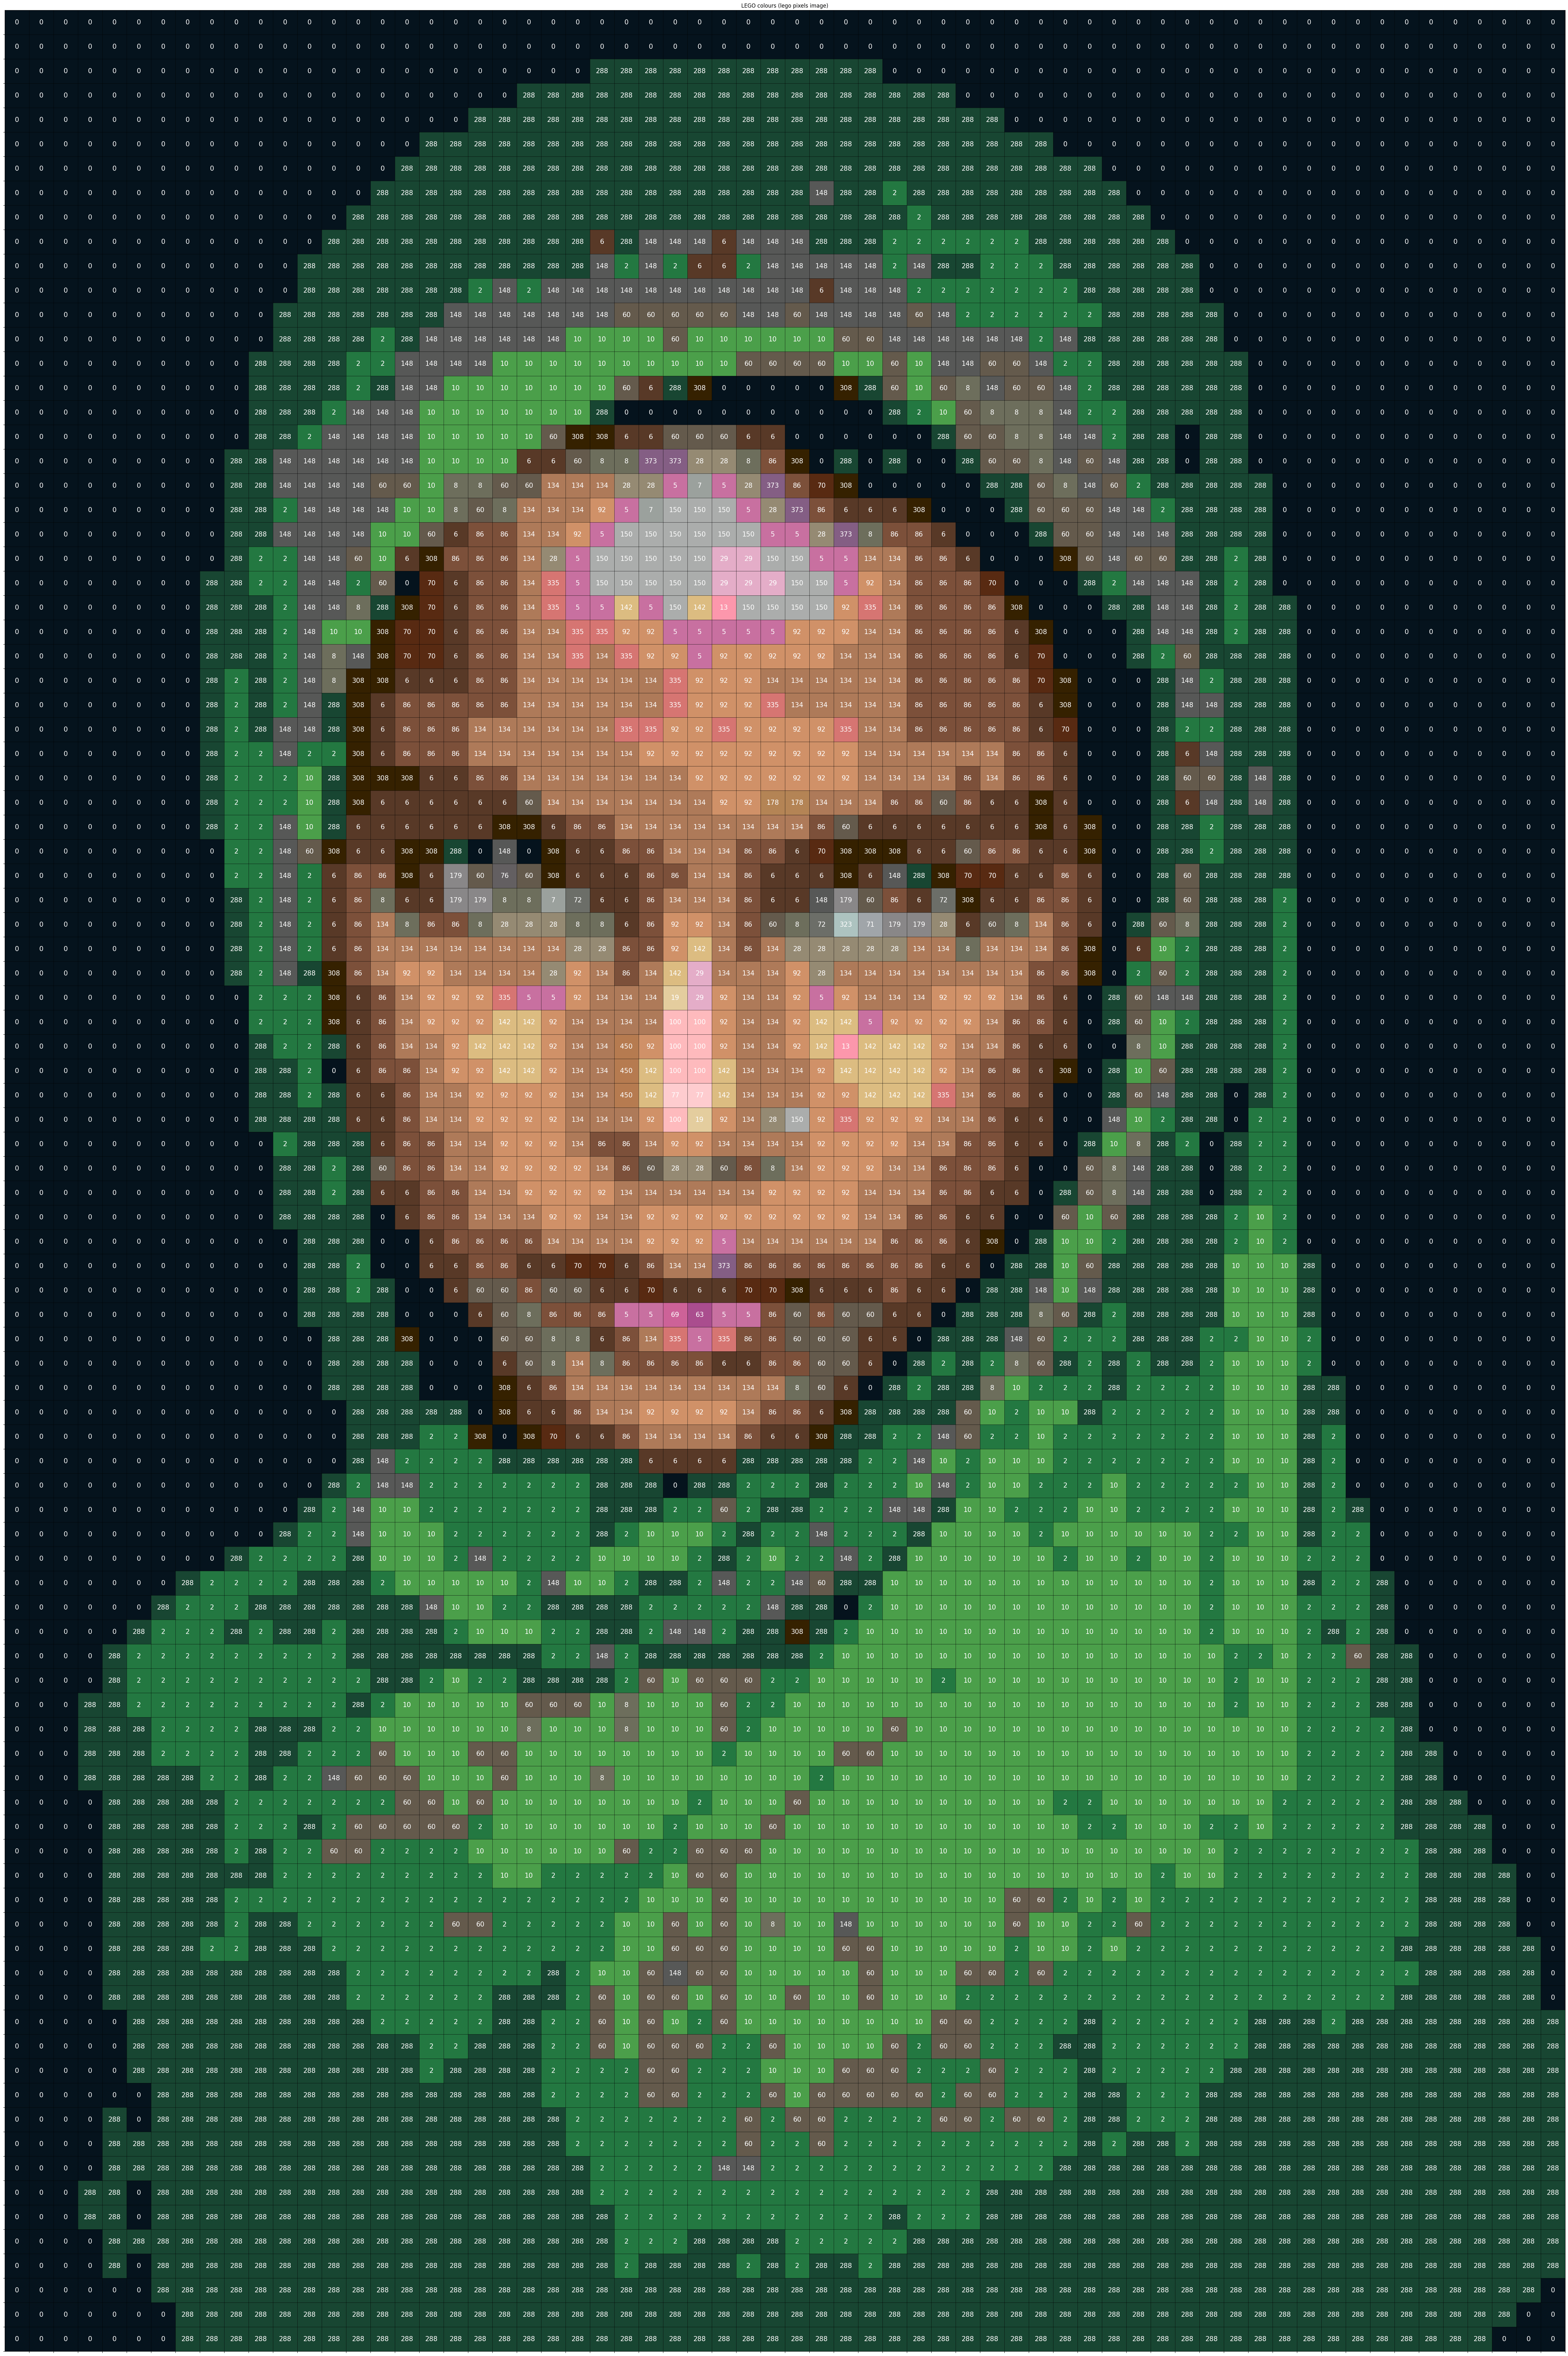

In [165]:
# Create a figure object and a subplot (1 row and 1 columns)
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)

# Use the subplot to show the grid of LEGO colours (lego pixels image)
ax1.imshow(indexed_colour_list, cmap=custom_cmap, norm=norm)
# Move the grid ticks to sit in between the pixes instead in the middle of the pixels
ax1.set_xticks([x-0.5 for x in list(range(1,indexed_colour_list.shape[1]+1))], range(1,indexed_colour_list.shape[1]+1), visible=False)  # Hide tick labels on the x axis
ax1.set_yticks([y-0.5 for y in list(range(1,indexed_colour_list.shape[0]+1))], range(1,indexed_colour_list.shape[0]+1), visible=False)  # Hide tick labels on the y axis
ax1.grid(which="major", color='black', linestyle='-', linewidth=0.5)  #Add grid lines on all major ticks
ax1.set_title('LEGO colours (lego pixels image)')  #Set the title of the subplot

for i in range(indexed_colour_list.shape[0]):
    for j in range(indexed_colour_list.shape[1]):
        text = ax1.text(j, i, indexed_colour_list[i, j], ha="center", va="center", fontsize=15, color="white")

# Set the figure size and save it for reference
fig.set_size_inches(lego_painting_size[0], lego_painting_size[1])
fig.savefig('lego pixels.pdf', bbox_inches='tight')